# G-ORFit for RMNIST

# 0. Imports

In [2]:
# %pip install flax
# %pip install git+https://github.com/probml/rebayes.git
# %pip install dynamax
# %pip install augly
# %pip install pylibmagic
# %pip install jax-tqdm

In [99]:
from typing import Callable
from functools import partial

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import seaborn as sns
import flax.linen as nn
from jax import jacrev, vmap, jit
from jax.flatten_util import ravel_pytree
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN

import pylibmagic
from rebayes.utils import datasets
from rebayes.utils.utils import get_mlp_flattened_params
from rebayes.orfit import ORFitParams, RebayesORFit, GeneralizedORFitParams
from rebayes.ekf import RebayesEKF
from rebayes.diagonal_inference import DEKFParams

In [8]:
class CNN(nn.Module):
    dim_out: int
    activation: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        x = x.reshape((1, 28, 28, 1))
        x = nn.Conv(6, (5, 5), padding="SAME")(x)
        x = self.activation(x)
        x = nn.avg_pool(x, (2, 2), padding="SAME")
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x).ravel()
        return x

In [9]:
def generate_rotated_images(images, angles, n_processes=1):
    n_configs = len(images)
    processer = datasets.DataAugmentationFactory(datasets.rotate_mnist)
    configs = [{"angle": float(angle)} for angle in angles]
    images_proc = processer(images, configs, n_processes=n_processes)
    return images_proc, angles

In [16]:
key = jr.PRNGKey(314)
key_init, key_train = jr.split(key)

dummy_input = jnp.ones(shape=(784,))

# Define the CNN model
cnn_model = CNN(1)
params = cnn_model.init(key, dummy_input)
flat_params, unflatten_fn = ravel_pytree(params)

# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

def apply_fn(w, x):
    y_eval = apply(w, x, model=cnn_model, unflatten_fn=unflatten_fn)
    return jnp.array([jnp.sin(y_eval/180*jnp.pi), jnp.cos(y_eval/180*jnp.pi)]).ravel()

# L2 loss
loss_fn = lambda w, x, y: (apply_fn(w, x) - y)**2

In [77]:
def orfit_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_basis, eps=1e-2):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    FU = F @ post_basis
    pred_cov = F @ F.T - FU @ FU.T + eps * jnp.eye(len(pred_mean))

    return pred_mean, pred_cov

In [100]:
def generate_dataset(target_digit):
    np.random.seed(314)
    train, test = datasets.load_rotated_mnist(target_digit=target_digit, minangle=-180)
    X_train, y_train = train
    X_test, y_test = test

    X_train = jnp.array(X_train)
    y_train = jnp.array(y_train)

    X_test = jnp.array(X_test)
    y_test = jnp.array(y_test)

    num_train, *dim_input = X_train.shape

    map_trench_1 = (y_train  >= -180) & (y_train <= -135)
    map_trench_2 = (y_train >= -90) & (y_train <= -45)
    map_trench = map_trench_1 | map_trench_2

    X_train = X_train[map_trench]
    y_train = y_train[map_trench]
    y_train = jnp.array([jnp.sin(y_train/180*jnp.pi), jnp.cos(y_train/180*jnp.pi)]).T

    return X_train, y_train, X_test, y_test

In [106]:
polar_to_angle = lambda trigs: jnp.arctan2(trigs[0], trigs[1]) * 180 / jnp.pi

In [107]:
def ppd_polar_to_angle(pred_mean, pred_cov, n_samples=200, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    def compute_posterior_predictive(mean, cov, key):
        mvn = MVN(loc=mean, covariance_matrix=cov)
        samples = mvn.sample(n_samples, seed=key)
        ppd_samples = vmap(polar_to_angle)(samples)
        ppd_mean, ppd_std = ppd_samples.mean(), ppd_samples.std()
        return ppd_mean, ppd_std
    
    keys = jr.split(key, len(pred_mean))
    ppd_means, ppd_stds = vmap(compute_posterior_predictive)(pred_mean, pred_cov, keys)
    
    return ppd_means, ppd_stds

In [117]:
def generate_generalized_orfit_results(target_digit, orfit_params):
    X_train, y_train, X_test, y_test = generate_dataset(target_digit)

    estimator = RebayesORFit(orfit_params, method='generalized_orfit')

    # Run Generalized ORFit on the dataset
    bel, _ = estimator.scan(X_train, y_train)

    # Analytically Compute PPD
    pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_test, bel.mean, bel.basis)

    pred_mean_angles = vmap(polar_to_angle)(pred_mean)

    # Plot results
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(y_test, pred_mean_angles, alpha=0.5, edgecolors=None)
    ax.set_ylabel("y-hat")
    ax.set_xlabel("y-true")
    xtrench1 = jnp.linspace(-135, -90, 100)
    xtrench2 = jnp.linspace(-45, 180, 500)
    ymin, ymax = plt.ylim()

    ax.axvline(x=-180, c="tab:gray", linestyle="--")
    ax.axvline(x=-135, c="tab:gray", linestyle="--")
    ax.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

    ax.axvline(x=-90, c="tab:gray", linestyle="--")
    ax.axvline(x=-45, c="tab:gray", linestyle="--")
    ax.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

    # plt.axhline(y=0, c="black")
    ax.plot([-180, 180], [-180, 180], c="black")

    ax.set_ylim(ymin, ymax)
    ax.legend()
    ax.grid(alpha=0.5);

# 1. R-MNIST Dataset

## Emission Noise = 1

In [133]:
gorfit_params1 = GeneralizedORFitParams(
    initial_mean=flat_params,
    initial_precision=1.0,
    dynamics_decay=0.0,
    dynamics_noise=0.0,
    emission_mean_function=apply_fn,
    emission_cov_function=lambda w, x: 1 * jnp.eye(2),
    memory_size=10
)
estimator1 = RebayesORFit(gorfit_params1, method='generalized_orfit')

  0%|          | 0/1693 [00:00<?, ?it/s]

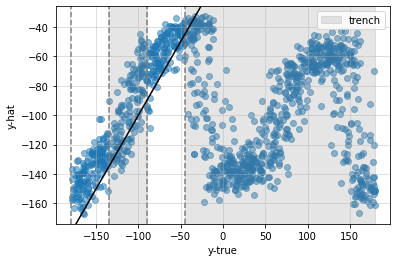

In [134]:
# Digit 1
generate_generalized_orfit_results(1, gorfit_params1)

  0%|          | 0/1486 [00:00<?, ?it/s]

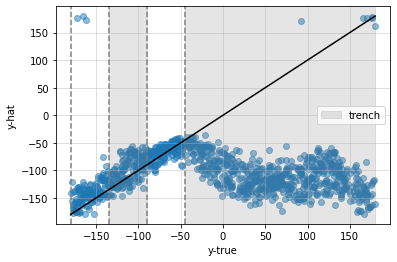

In [135]:
# Digit 2
generate_generalized_orfit_results(2, gorfit_params1)

  0%|          | 0/1531 [00:00<?, ?it/s]

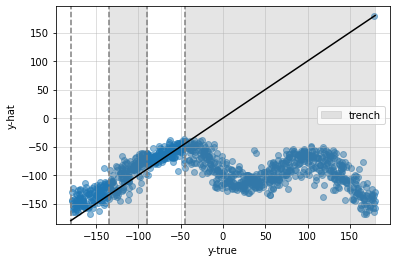

In [136]:
# Digit 3
generate_generalized_orfit_results(3, gorfit_params1)

  0%|          | 0/1460 [00:00<?, ?it/s]

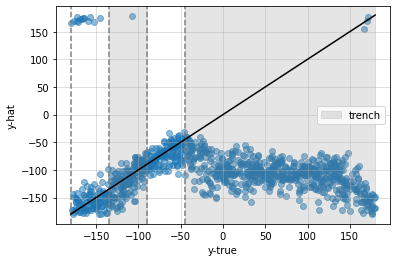

In [137]:
# Digit 4
generate_generalized_orfit_results(4, gorfit_params1)

  0%|          | 0/1363 [00:00<?, ?it/s]

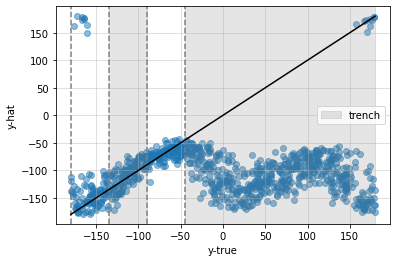

In [138]:
# Digit 5
generate_generalized_orfit_results(5, gorfit_params1)

  0%|          | 0/1476 [00:00<?, ?it/s]

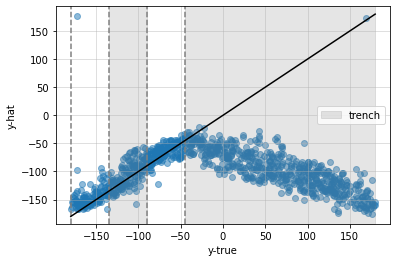

In [139]:
# Digit 6
generate_generalized_orfit_results(6, gorfit_params1)

  0%|          | 0/1573 [00:00<?, ?it/s]

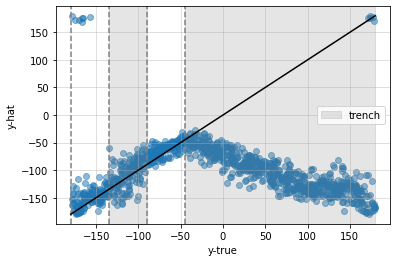

In [140]:
# Digit 7
generate_generalized_orfit_results(7, gorfit_params1)

  0%|          | 0/1463 [00:00<?, ?it/s]

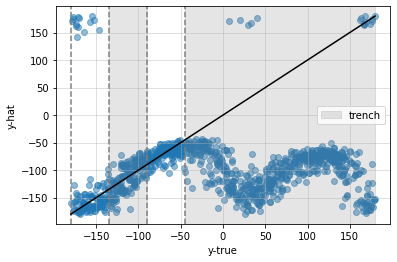

In [141]:
# Digit 8
generate_generalized_orfit_results(8, gorfit_params1)

  0%|          | 0/1481 [00:00<?, ?it/s]

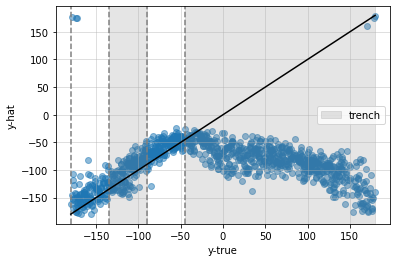

In [142]:
# Digit 9
generate_generalized_orfit_results(9, gorfit_params1)

## Emission Noise = 1e-2

In [143]:
gorfit_params2 = GeneralizedORFitParams(
    initial_mean=flat_params,
    initial_precision=1.0,
    dynamics_decay=0.0,
    dynamics_noise=0.0,
    emission_mean_function=apply_fn,
    emission_cov_function=lambda w, x: 1e-2 * jnp.eye(2),
    memory_size=10
)
estimator2 = RebayesORFit(gorfit_params2, method='generalized_orfit')

  0%|          | 0/1693 [00:00<?, ?it/s]

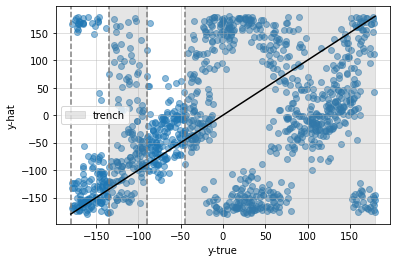

In [144]:
# Digit 1
generate_generalized_orfit_results(1, gorfit_params2)

  0%|          | 0/1486 [00:00<?, ?it/s]

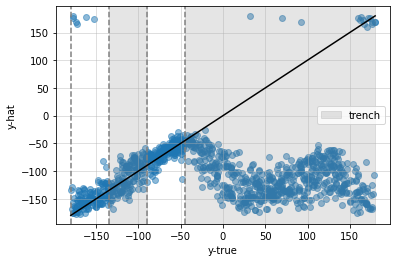

In [145]:
# Digit 2
generate_generalized_orfit_results(2, gorfit_params2)

  0%|          | 0/1531 [00:00<?, ?it/s]

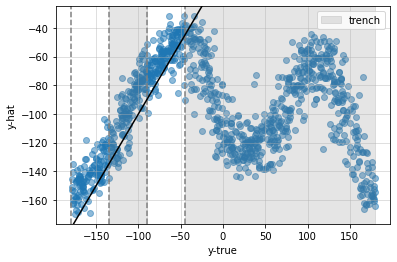

In [146]:
# Digit 3
generate_generalized_orfit_results(3, gorfit_params2)

  0%|          | 0/1460 [00:00<?, ?it/s]

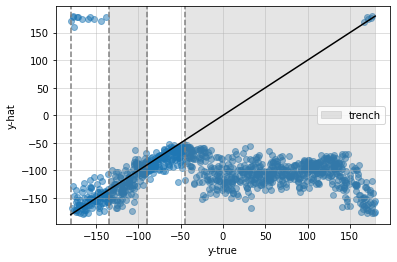

In [147]:
# Digit 4
generate_generalized_orfit_results(4, gorfit_params2)

  0%|          | 0/1363 [00:00<?, ?it/s]

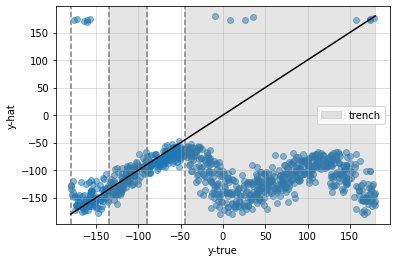

In [148]:
# Digit 5
generate_generalized_orfit_results(5, gorfit_params2)

  0%|          | 0/1476 [00:00<?, ?it/s]

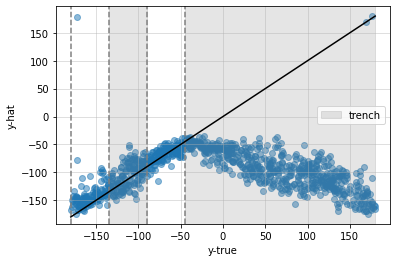

In [149]:
# Digit 6
generate_generalized_orfit_results(6, gorfit_params2)

  0%|          | 0/1573 [00:00<?, ?it/s]

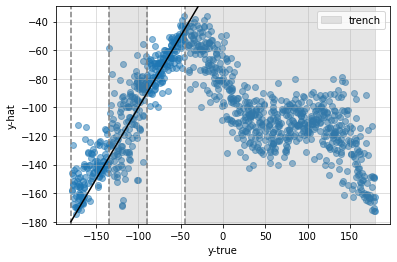

In [150]:
# Digit 7
generate_generalized_orfit_results(7, gorfit_params2)

  0%|          | 0/1463 [00:00<?, ?it/s]

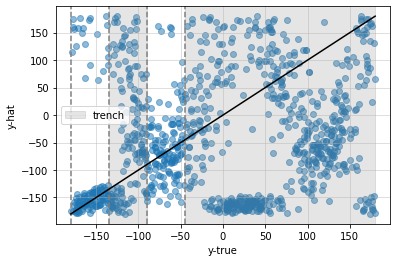

In [151]:
# Digit 8
generate_generalized_orfit_results(8, gorfit_params2)

  0%|          | 0/1481 [00:00<?, ?it/s]

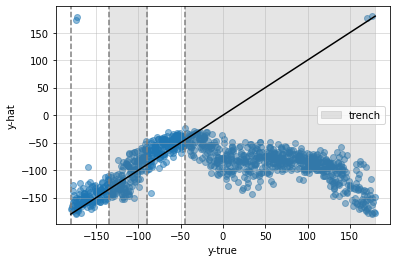

In [152]:
# Digit 9
generate_generalized_orfit_results(9, gorfit_params2)